<a href="https://colab.research.google.com/github/juanmggb/maestria/blob/main/ml_batch/time_stepper_euler_rk4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install smt

In [ ]:
pip install torchdyn

In [ ]:
pip install pyDOE

In [5]:
from argparse import ArgumentParser
from numpy import double
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
from pyDOE import lhs
import matplotlib.pyplot as plt
from torch.nn.functional import mse_loss
import numpy as np
import torch
from torchdyn.numerics import odeint
# from torchdyn.numerics.solvers import SolverTemplate
import matplotlib.patches as mpatches
from matplotlib.collections import LineCollection
# from visualization import get_meshgrid, plot_colored

### Solvers

In this case, SolverTemplate and DirectSolver are not necessarily representing a neural network, but they are using nn.Module as a base class to take advantage of the aforementioned benefits.

In [6]:
class SolverTemplate(nn.Module):
    # def __init__(self, order, min_factor: float = 0.2, max_factor: float = 10, safety: float = 0.9):
    def __init__(self):
        super().__init__()
        # self.order = order
        # self.min_factor = torch.tensor([min_factor])
        # self.max_factor = torch.tensor([max_factor])
        # self.safety = torch.tensor([safety])
        # self.tableau = None

    def sync_device_dtype(self, x, t_span):
        "Ensures `x`, `t_span`, `tableau` and other solver tensors are on the same device with compatible dtypes"

        if isinstance(x, dict):
            proto_arr = x[list(x.keys())[0]]
        elif isinstance(x, torch.Tensor):
            proto_arr = x
        else:
            raise NotImplementedError(
                f"{type(x)} is not supported as the state variable")

        device = proto_arr.device

        # if self.tableau is not None:
        #     c, a, bsol, berr = self.tableau
        #     self.tableau = c.to(proto_arr), [a.to(proto_arr) for a in a], bsol.to(
        #         proto_arr), berr.to(proto_arr)
        t_span = t_span.to(device)
        # self.safety = self.safety.to(device)
        # self.min_factor = self.min_factor.to(device)
        # self.max_factor = self.max_factor.to(device)
        return x, t_span

    def step(self, f, x, t, dt, k1=None, args=None):
        pass


class DirectSolver(SolverTemplate):
    def __init__(self, dtype=torch.float32):
        # super().__init__(order=1)
        super().__init__()
        self.dtype = dtype
        self.stepping_class = "fixed"

    def step(self, f, x, t, dt, k1=None, args=None):

        x_sol = f(t, x)
        return None, x_sol, None

class ResnetSolver(SolverTemplate):
    def __init__(self, step_size=None, dtype=torch.float32):
        # super().__init__(order=1)
        super().__init__()
        self.dtype = dtype
        self.stepping_class = "fixed"

        self.step_size = 1 if step_size is None else step_size

    def step(self, f, x, t, dt, k1=None, args=None):
        x_sol = x + f(t, x) * self.step_size
        return None, x_sol, None

### Generate data

In [8]:
# generate data

def f(t, x):
    θ = x[..., 0]
    ω = x[..., 1]

    dθ = ω
    dω = -torch.sin(θ)

    return torch.stack((dθ, dω), dim=-1)


domain_train = 1.0
domain_validate = 1.0

x0_train = (
    torch.tensor(lhs(2, 100), 
                 device='cpu') * 2 - 1
) * domain_train

x0_validate = (
    torch.tensor(lhs(2, 10), 
                 device='cpu') * 2 - 1
) * domain_validate

# x0_grid = get_meshgrid(step_per_axis=0.01, domain=domain_validate)
x0_example = torch.tensor((0.6, 0)).double().unsqueeze(0).to('cpu')

step_size_train = 0.001
ε = 1e-10
t_span_train = torch.arange(
    0.0,0.001 + ε, step_size_train
)
t_span_validate = torch.arange(
    0.0,
    4*np.pi + ε,
    step_size_train,
)

In [9]:
# print(x0_grid.shape)
print(x0_train.shape)
print(x0_validate.shape)

torch.Size([100, 2])
torch.Size([10, 2])


In [10]:
# print(x0_grid[0])

In [11]:
_, x_train = odeint(f, x0_train, t_span_train, solver="rk4") # returns (t_eval, solution)
# x_true = x_train
# x_train = x_train + torch.randn_like(x_train) * 0.0

_, x_validate = odeint(f, x0_validate, t_span_validate, solver="rk4")

_, x_example = odeint(f, x0_example, t_span_validate, solver="rk4")

In [13]:
# choices=["direct", "resnet", "euler", "rk4"],
# solver = DirectSolver()
# solver = ResnetSolver()
solver = 'rk4'

### Model

In [14]:
##################### model ##########################
layers = []
layers.append(nn.Linear(2, 32))
for _ in range(8):
    layers.append(nn.Linear(32, 32))
    layers.append(nn.Softplus())

layers.append(nn.Linear(32, 2))

net = nn.Sequential(*layers)
net.to('cpu').double()

for m in net.modules():
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

### Training

In [15]:
# optimizer

opt = Adam(net.parameters())

# train
losses = []

In [16]:
solver

'rk4'

Certainly! In step 1 of the training loop, the model makes a forward pass through the ODE solver. This means that the ODE solver is used to solve an ordinary differential equation (ODE) using the neural network as the function being solved.

The ODE solver is called with the following arguments:

A function that defines the ODE. In this case, the function is the neural network itself. The function takes in two arguments: a time t and a tensor of states x. It returns the derivative of x with respect to t, calculated using the neural network.

An initial tensor of states x0_train. This is the starting point for the ODE solver. The shape of x0_train (shape (100,2)) determines the shape of the input to the neural network.

A time span t_span_train (tensor([0.0000, 0.0010])). This specifies the range of times over which the ODE should be solved. The ODE solver will evaluate the function at evenly spaced intervals within this time span.

An optional solver argument, which specifies the method that the ODE solver should use to solve the ODE. If this argument is not provided, the ODE solver will use a default solver.

The ODE solver returns two values: a tensor of time points t and a tensor of states x. In this code, the time points tensor is discarded and only the states tensor is kept. The shape of the states tensor will be (num_time_points->2, batch_size->100, 2), where num_time_points is the number of time points within the time span and batch_size is the batch size of the input. The last dimension has size 2 because the model has an output size of 2.

The states tensor is then stored in a variable x_pred_train, which will be used in the next step to calculate the loss.

In [17]:
##################### training ##########################
for _ in tqdm(range(2000)):

    # 1. Forward pass: The model makes ONE forward pass through the ODE solver, using
    #  the input tensor x0_train and the time span t_span_train.
    #  The function being solved by the ODE solver is the neural network itself,
    #  which is passed as an argument to the ODE solver.
    _, x_pred_train = odeint(
        lambda t, x: net(x), 
        x0_train,
        t_span_train, 
        solver=solver
    )
    
    # 2. Calculate loss: Take the mean error over the 100 trajectories
    loss = mse_loss(x_pred_train, x_train)

    # 3. Zero grad
    opt.zero_grad()

    # 4. Backward pass
    loss.backward()

    # 5. Update weights
    opt.step()
    
    losses.append(loss.item())

100%|██████████| 2000/2000 [00:19<00:00, 101.14it/s]


In [18]:
print(x0_train.shape)
print(x_pred_train.shape)
print(x_train.shape)

torch.Size([100, 2])
torch.Size([2, 100, 2])
torch.Size([2, 100, 2])


In [19]:
try:
    print(np.mean((x_pred_train.detach().numpy() - x_train.detach().numpy())**2))
    print(loss)
except:
    pass

1.6896759740124775e-10
tensor(1.6897e-10, dtype=torch.float64, grad_fn=<MseLossBackward0>)


### Validation

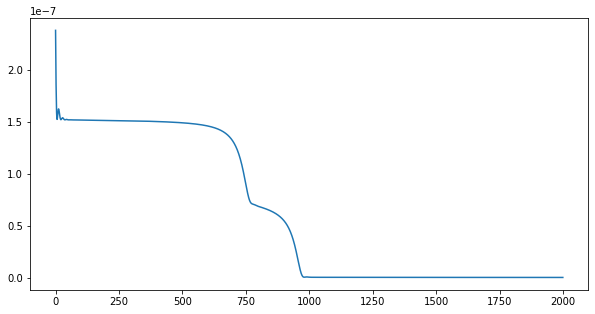

In [20]:
plt.figure(figsize=(10,5))
plt.plot(losses)

In [21]:
# _, x_pred_train = odeint(lambda t, x: net(x), x0_train, t_span_train, solver=solver)

In [22]:
_, x_pred_validate = odeint(
    lambda t, x: net(x), x0_validate, t_span_validate, solver=solver
)

In [23]:
_, x_pred_example = odeint(
    lambda t, x: net(x), x0_example, t_span_validate, solver=solver
)

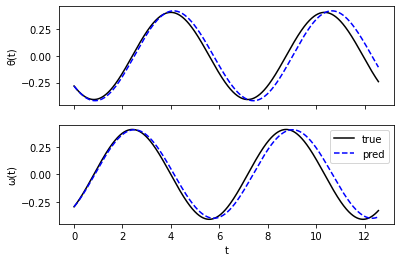

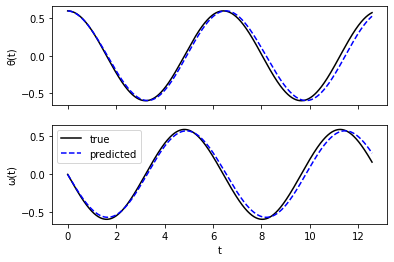

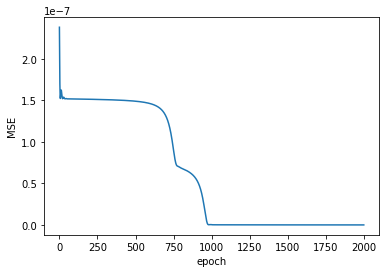

In [24]:
 # @title plot
try:
    # x_pred_train = x_pred_train.detach().numpy()
    x_pred_validate = x_pred_validate.detach().numpy()
    x_pred_example = x_pred_example.detach().numpy()
    # x_derivative_pred = x_derivative_pred.detach().numpy()
    # x_derivative = x_derivative.detach().numpy()
    # x0_grid = x0_grid.detach().numpy()


    # time series validation, specific idx
    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    example_idx = 0

    ax1.plot(t_span_validate, x_validate[..., example_idx, 0], color="black")
    ax1.plot(
        t_span_validate,
        x_pred_validate[..., example_idx, 0],
        linestyle="dashed",
        color="blue",
    )

    ax2.plot(
        t_span_validate, x_validate[..., example_idx, 1], color="black", label="true"
    )
    ax2.plot(
        t_span_validate,
        x_pred_validate[..., example_idx, 1],
        linestyle="dashed",
        color="blue",
        label="pred",
    )
    ax1.set_ylabel("θ(t)")
    ax2.set_ylabel("ω(t)")
    ax2.set_xlabel("t")
    ax2.legend()

    # time series validation, example (0.6,0)
    fig, (ax1, ax2) = plt.subplots(2, sharex=True)

    ax1.plot(t_span_validate, x_example[..., 0], color="black")
    ax1.plot(
        t_span_validate,
        x_pred_example[..., 0],
        linestyle="dashed",
        color="blue",
    )
    
    ax2.plot(t_span_validate, x_example[..., 1], label="true", color="black")
    ax2.plot(
        t_span_validate,
        x_pred_example[..., 1],
        linestyle="dashed",
        color="blue",
        label="predicted",
    )
    ax1.set_ylabel("θ(t)")
    ax2.set_ylabel("ω(t)")
    ax2.set_xlabel("t")
    ax2.legend()

    # show
    fig, ax = plt.subplots()
    ax.plot(losses)
    ax.set_xlabel("epoch")
    ax.set_ylabel("MSE")

    plt.show()

except:
    pass